<a href="https://colab.research.google.com/github/ar851060/TabularWithBert/blob/main/BertwithTabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Transformers Library

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

# specify GPU
np.random.seed(42)
device = torch.device("cuda")

# Load Dataset

data source: https://www.kaggle.com/datasets/iamsouravbanerjee/data-science-salaries-2023

In [ ]:
df = pd.read_csv("/content/v2_Latest_Data_Science_Salaries.csv").drop(["Salary","Salary Currency"], axis = 1)
df.head()

,Job Title,Employment Type,Experience Level,Expertise Level,Company Location,Salary in USD,Employee Residence,Company Size,Year
0,Machine Learning Manager,Full-Time,Senior,Expert,United States,129562,Germany,Large,2023
1,BI Data Analyst,Full-Time,Entry,Junior,Kenya,50000,Kenya,Small,2023
2,AI Engineer,Full-Time,Senior,Expert,United States,227850,United States,Medium,2023
3,AI Engineer,Full-Time,Senior,Expert,United States,180500,United States,Medium,2023
4,Data Analyst,Full-Time,Mid,Intermediate,United States,90000,United States,Medium,2023


In [ ]:
df.shape

(3470, 9)

# Split train dataset into train, validation and test sets

In [ ]:
cols = df.columns.values.tolist()
cols.remove("Salary in USD")
df["text"] = ["[CLS]" + str(i).replace("'","").replace("{","").replace("}","") + "[SEP]" for i in df.to_dict("records")]
df = df.drop(cols, axis = 1)
train_text, temp_df, train_labels, temp_labels = train_test_split(df.drop("Salary in USD", axis = 1), df['Salary in USD'])
# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_df, temp_labels)

In [ ]:
print(train_text.shape)
print(val_text.shape)
print(test_text.shape)

(2602, 1)
(651, 1)
(217, 1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_labels = scaler.fit_transform(np.array(train_labels).reshape(-1, 1))
val_labels = scaler.transform(np.array(val_labels).reshape(-1, 1))
test_labels = scaler.transform(np.array(test_labels).reshape(-1, 1))

# Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

<Axes: >

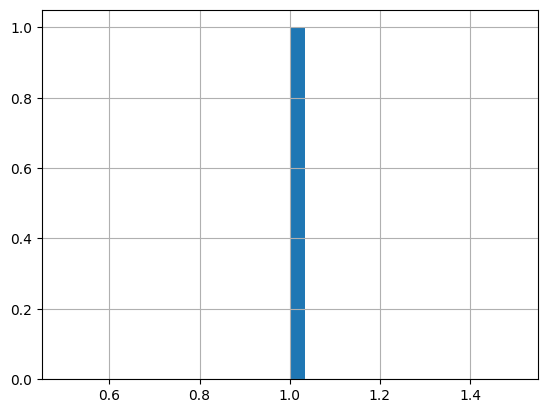

In [ ]:
# get length of all the messages in the train set

seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text["text"].tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text["text"].tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text["text"].tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 8

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,1)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      cls_hs = self.bert(sent_id, attention_mask=mask)

      x = self.fc1(cls_hs[1])

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
    #   x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Find Class Weights

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight

# #compute the class weights
# class_wts = compute_class_weight(class_weight = 'balanced',  classes = np.unique(train_labels), y = train_labels)

# print(class_wts)

In [ ]:
# convert class weights to tensor
# weights= torch.tensor(class_wts,dtype=torch.float)
# # weights = weights.to(device)

# # loss function
# cross_entropy  = nn.NLLLoss(weight=weights)
mse_loss = nn.MSELoss()
# number of training epochs
epochs = 20

# Fine-Tune BERT

In [ ]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 500 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch
    labels = labels.type(torch.FloatTensor)

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values

    # loss = cross_entropy(preds.cuda(), labels.cuda())
    loss = mse_loss(preds.cuda(), labels.cuda())


    # add on to the total loss
    total_loss = total_loss + loss.mean()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
import time
from babel.dates import format_time
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 500 == 0 and not step == 0:

      # Calculate elapsed time in minutes.

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch
    labels = labels.type(torch.FloatTensor)

    # deactivate autograd
    with torch.no_grad():

      # model predictions

      preds = model(sent_id, mask)


      # compute the validation loss between actual and predicted values
    #   loss = cross_entropy(preds.cuda(), labels.cuda())
      loss = mse_loss(preds.cuda(), labels.cuda())

      total_loss = total_loss + loss.mean()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20

Evaluating...

Training Loss: 0.060
Validation Loss: 0.026

 Epoch 2 / 20

Evaluating...

Training Loss: 0.030
Validation Loss: 0.031

 Epoch 3 / 20

Evaluating...

Training Loss: 0.028
Validation Loss: 0.024

 Epoch 4 / 20

Evaluating...

Training Loss: 0.028
Validation Loss: 0.030

 Epoch 5 / 20

Evaluating...

Training Loss: 0.028
Validation Loss: 0.024

 Epoch 6 / 20

Evaluating...

Training Loss: 0.027
Validation Loss: 0.023

 Epoch 7 / 20

Evaluating...

Training Loss: 0.027
Validation Loss: 0.023

 Epoch 8 / 20

Evaluating...

Training Loss: 0.027
Validation Loss: 0.023

 Epoch 9 / 20

Evaluating...

Training Loss: 0.026
Validation Loss: 0.024

 Epoch 10 / 20

Evaluating...

Training Loss: 0.026
Validation Loss: 0.023

 Epoch 11 / 20

Evaluating...

Training Loss: 0.026
Validation Loss: 0.025

 Epoch 12 / 20

Evaluating...

Training Loss: 0.026
Validation Loss: 0.022

 Epoch 13 / 20

Evaluating...

Training Loss: 0.025
Validation Loss: 0.024

 Epoch 14 / 20

Eval

# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
from sklearn.metrics import mean_squared_error
print(mean_squared_error(test_y, preds))

0.020424204


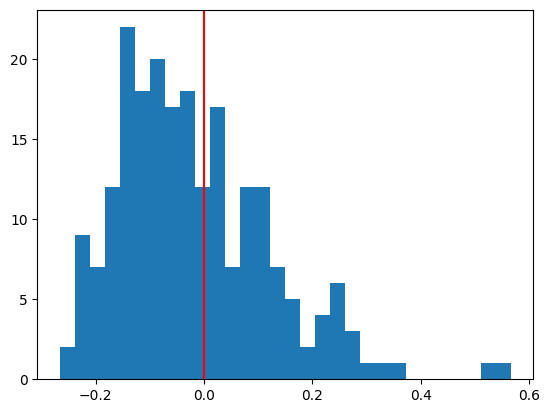

In [ ]:
import matplotlib.pyplot as plt
plt.hist((test_y.flatten()-preds.flatten()), bins = 30)
plt.axvline(x = 0, color = "red")